<a href="https://colab.research.google.com/github/HimanshuRajput013/Text-to-Image-Generator-with-Stable-Diffusion/blob/main/Text_to_image_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Install compatible versions
!pip install diffusers==0.27.2 transformers accelerate safetensors gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.27.2
    Uninstalling diffusers-0.27.2:
      Successfully uninstalled diffusers-0.27.2


In [7]:
# Import necessary libraries
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image
import os
import time
import numpy as np

In [8]:
class TextToImageGenerator:

    def __init__(self, model_id="runwayml/stable-diffusion-v1-5", device=None):

        self.model_id = model_id
        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        print(f"Using device: {self.device}")

        self.pipe = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
            safety_checker=None)
        self.pipe.scheduler = DPMSolverMultistepScheduler.from_config(self.pipe.scheduler.config)
        self.pipe.to(self.device)
        if self.device == "cuda":
            self.pipe.enable_attention_slicing()

    def generate_image(self,
                       prompt,
                       negative_prompt=None,
                       height=512,
                       width=512,
                       num_inference_steps=30,
                       guidance_scale=7.5,
                       seed=None):

        generator = None
        if seed is not None:
            generator = torch.Generator(device=self.device).manual_seed(seed)


        start_time = time.time()
        with torch.no_grad():
            result = self.pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                generator=generator
            )
        end_time = time.time()

        print(f"Image generated in {end_time - start_time:.2f} seconds")
        return result.images[0]

    def save_image(self, image, output_dir="generated_images", filename=None):
        os.makedirs(output_dir, exist_ok=True)
        if filename is None:
            filename = f"generated_{int(time.time())}.png"
        elif not filename.endswith(".png"):
            filename = f"{filename}.png"

        output_path = os.path.join(output_dir, filename)
        image.save(output_path)
        print(f"Image saved to {output_path}")

        return output_path


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/30 [00:00<?, ?it/s]

Image generated in 7.98 seconds


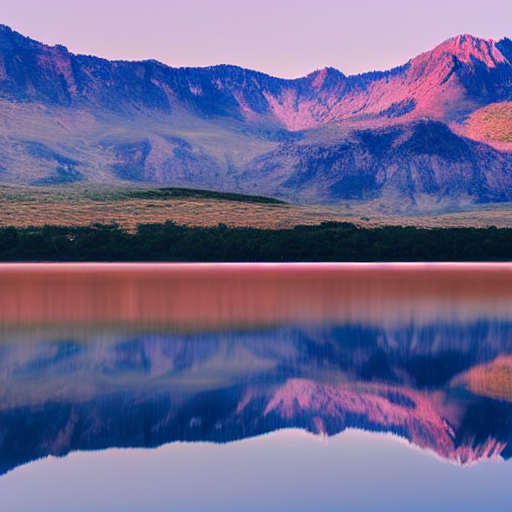

In [9]:
# Test the generator with a simple prompt
generator = TextToImageGenerator()
test_prompt = "A serene landscape with mountains,sun reflected in a calm lake at sunset"
test_image = generator.generate_image(test_prompt)
display(test_image)  # Display the image directly in the notebook

In [ ]:
# %%
import gradio as gr
import random

def generate_image_from_prompt(
    prompt,
    negative_prompt,
    width,
    height,
    num_inference_steps,
    guidance_scale,
    seed,
    use_random_seed
):
    """
    Generate an image using the Stable Diffusion model based on UI inputs.
    """
    # Use a random seed if specified
    if use_random_seed:
        seed = random.randint(0, 2147483647)

    # Set seed to None if it's -1 (No seed)
    if seed == -1:
        seed = None

    # Generate the image
    start_time = time.time()
    image = generator.generate_image(
        prompt=prompt,
        negative_prompt=negative_prompt,
        width=width,
        height=height,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        seed=seed
    )
    end_time = time.time()

    # Create info for display
    generation_info = f"""
    **Generation Info:**
    - Prompt: {prompt}
    - Negative Prompt: {negative_prompt if negative_prompt else 'None'}
    - Size: {width}x{height}
    - Steps: {num_inference_steps}
    - Guidance Scale: {guidance_scale}
    - Seed: {seed if seed is not None else 'Random'}
    - Generation Time: {end_time - start_time:.2f} seconds
    """

    return image, generation_info, seed

# Create the Gradio interface
with gr.Blocks(title="Stable Diffusion Text-to-Image Generator") as app:
    gr.Markdown("# Text-to-Image Generator")
    gr.Markdown("Generate images from text prompts using Stable Diffusion.")

    with gr.Row():
        with gr.Column(scale=2):
            # Input controls
            prompt = gr.Textbox(
                label="Prompt",
                placeholder="A serene landscape with mountains reflected in a calm lake at sunset",
                lines=3
            )
            negative_prompt = gr.Textbox(
                label="Negative Prompt",
                placeholder="blurry, distorted, low quality, low resolution",
                lines=2
            )

            with gr.Row():
                width = gr.Slider(label="Width", minimum=256, maximum=1024, value=512, step=64)
                height = gr.Slider(label="Height", minimum=256, maximum=1024, value=512, step=64)

            with gr.Row():
                num_inference_steps = gr.Slider(
                    label="Inference Steps",
                    minimum=10,
                    maximum=100,
                    value=30,
                    step=1,
                    info="More steps = higher quality but slower generation"
                )
                guidance_scale = gr.Slider(
                    label="Guidance Scale",
                    minimum=1.0,
                    maximum=15.0,
                    value=7.5,
                    step=0.5,
                    info="How closely to follow the prompt (higher = more faithful)"
                )

            with gr.Row():
                seed = gr.Number(
                    label="Seed",
                    value=-1,
                    precision=0,
                    info="Set to -1 for random seed each time"
                )
                use_random_seed = gr.Checkbox(label="Use Random Seed", value=True)

            # Generate button
            generate_btn = gr.Button("Generate Image", variant="primary")

        with gr.Column(scale=3):
            # Outputs
            image_output = gr.Image(label="Generated Image", type="pil")
            info_output = gr.Markdown(label="Generation Info")
            seed_output = gr.Number(label="Used Seed", precision=0)

    # Set up the generation event
    generate_btn.click(
        fn=generate_image_from_prompt,
        inputs=[
            prompt,
            negative_prompt,
            width,
            height,
            num_inference_steps,
            guidance_scale,
            seed,
            use_random_seed
        ],
        outputs=[image_output, info_output, seed_output]
    )

    # Example prompts for quick testing
    gr.Examples(
        examples=[
            ["A serene landscape with mountains reflected in a calm lake at sunset",
             "blurry, distorted", 512, 512, 30, 7.5, -1, True],
            ["A cyberpunk cityscape at night with neon lights and flying cars",
             "low quality, unrealistic", 640, 512, 40, 8.0, -1, True],
            ["A photorealistic portrait of a futuristic robot with detailed mechanical features",
             "cartoon, anime, sketch", 512, 512, 50, 9.0, -1, True],
            ["A magical forest with glowing fireflies and mystical creatures",
             "dark, scary, blurry", 512, 640, 35, 7.0, -1, True],
        ],
        inputs=[
            prompt,
            negative_prompt,
            width,
            height,
            num_inference_steps,
            guidance_scale,
            seed,
            use_random_seed
        ],
    )


In [ ]:
# Launch the Gradio interface, clink on link
app.launch(debug=True, share=True)

In [ ]:
# Example of generating and saving an image
def generate_and_save_image(prompt, filename=None):
    image = generator.generate_image(prompt)
    path = generator.save_image(image, filename=filename)
    display(image)
    return path

# write your prompt
saved_path = generate_and_save_image(
    "A photorealistic portrait of a futuristic robot with detailed mechanical features",
    "futuristic robot"
)
print(f"Image saved to: {saved_path}")